In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from utils.filepaths.filepaths import FILE_PATH_FLOW_LOOP_DATA

from utils.training.training import k_fold_cross_validation_sklearn_models
from utils.utils.utils import change_directory

In [51]:
with open(FILE_PATH_FLOW_LOOP_DATA, 'r')as file:
    data = file.readlines()
    changed_data = []
    for line in data:
        changed_line = line.strip().split('\t')
        changed_data.append(changed_line)
        

In [52]:
df = pd.DataFrame(data=changed_data[1:], columns = changed_data[0])
df = df.drop(index = 0)

In [53]:
print(df.columns)
df = df[df["Cuttings conc quality"]=='1']
df = df.sample(frac=1).reset_index(drop=True)


Index(['mean File name', 'mean StartTime', 'mean EndTime', 'mean DPT1',
       'mean DPT2', 'mean DPT3', 'mean Torque', 'mean MudDensity',
       'mean Tankweight', 'mean TempTank', 'mean SandRate', 'mean Flow',
       'mean DPT4', 'mean DPR1', 'mean DPR2', 'mean TestSectionWeight',
       'mean SetPoint', 'mean USL', 'mean StringRPM',
       'mean relBedHeightTankWeight', 'mean relBedHeightTestSectionWeight',
       'mean fricCoeff', 'std DPT1', 'std DPT2', 'std DPT3', 'std Torque',
       'std MudDensity', 'std Tankweight', 'std TempTank', 'std SandRate',
       'std Flow', 'std DPT4', 'std DPR1', 'std DPR2', 'std TestSectionWeight',
       'std SetPoint', 'std USL', 'std StringRPM',
       'std relBedHeightTankWeight', 'std relBedHeightTestSectionWeight',
       'std fricCoeff', 'drift DPT1', 'drift DPT2', 'drift DPT3',
       'drift Torque', 'drift MudDensity', 'drift Tankweight',
       'drift TempTank', 'drift SandRate', 'drift Flow', 'drift DPT4',
       'drift DPR1', 'drift DPR

In [54]:
# No flow behavior index since I am not sure if I can use that for field data
# Friction coefficient had many nan values. See what to do about this later
# Might not need it as you probably do not have it for field
print(df["Eccentricity"].unique())
dict_of_variables = {
    "Slip ratio" : df["Particle slip ratio in test section"].astype("float32"),
    "Eccentricity" : df["Eccentricity"].astype("float32"),
    "Inclination" : df["Inclination"],
    "Reynolds" : df["Reynolds annulus (no cuttings)"].astype("float32"),
    "Taylor" : df["Taylor number"].astype("float32"),
    "Shields" : df["Shields number"].astype("float32"),
    "Froude" : df["Froude number"].astype("float32"),
    "Bingham" : df["Bingham number"].astype("float32"),
    "Fluid name": df["Fluid name"]
    # "Friction coef" : df["mean fricCoeff"].astype("float32"),
}
df = pd.DataFrame(dict_of_variables)
df["Eccentricity"].unique()
df = df[(df!=0).all(axis=1)]

['0.5' '1']


In [55]:
# Encoding fluid categorically
print(df["Eccentricity"].unique())
fluid_mapping = {'EMSVersatec' : 1.0, 'Glydril': 0.0}
df["Fluid name"] = df["Fluid name"].map(fluid_mapping)
# Likewise for inclination
inclination_mapping = {'90' : 2.0, '60' : 1.0, '48': 0.0}
df["Inclination"] = df["Inclination"].map(inclination_mapping)
print(df["Slip ratio"].unique())


[1.  0.5]
[0.711259  0.264743  0.693481  0.737844  0.195381  0.381762  0.233205
 0.584945  0.102187  0.915504  1.        0.421603  0.451238  0.2121
 0.570434  0.114617  0.372572  0.38472   0.379493  0.553985  0.194474
 0.482481  0.0977207 0.300785  0.0856569 0.321209  0.317746  0.722696
 0.640981  0.411546  0.173783  0.231479  0.560577  0.432301  0.18192
 0.078139  0.278417  0.964522  0.570801  0.238455  0.81547   0.839277
 0.392291  0.515822  0.431419  0.237097  0.36945   0.102412  0.328141
 0.353913  0.575925  0.0691023 0.188358  0.638568  0.349167  0.0927884
 0.358872  0.0432605 0.669824  0.374044  0.0821892 0.139438  0.0890773
 0.0636316 0.312581  0.548815  0.104448  0.434177  0.883381  0.308066
 0.193785  0.264289  0.568153  0.0755612 0.371048  0.0721444 0.871206
 0.303072  0.0858607 0.469321  0.0652629 0.787898  0.939416  0.652175
 0.34384   0.351515  0.106909  0.336475  0.456334  0.667095  0.641373 ]


In [56]:
# Modify values based on the condition
threshold = 0.5
df["Slip ratio"] = df["Slip ratio"].apply(lambda x: 0 if x > threshold else 1)

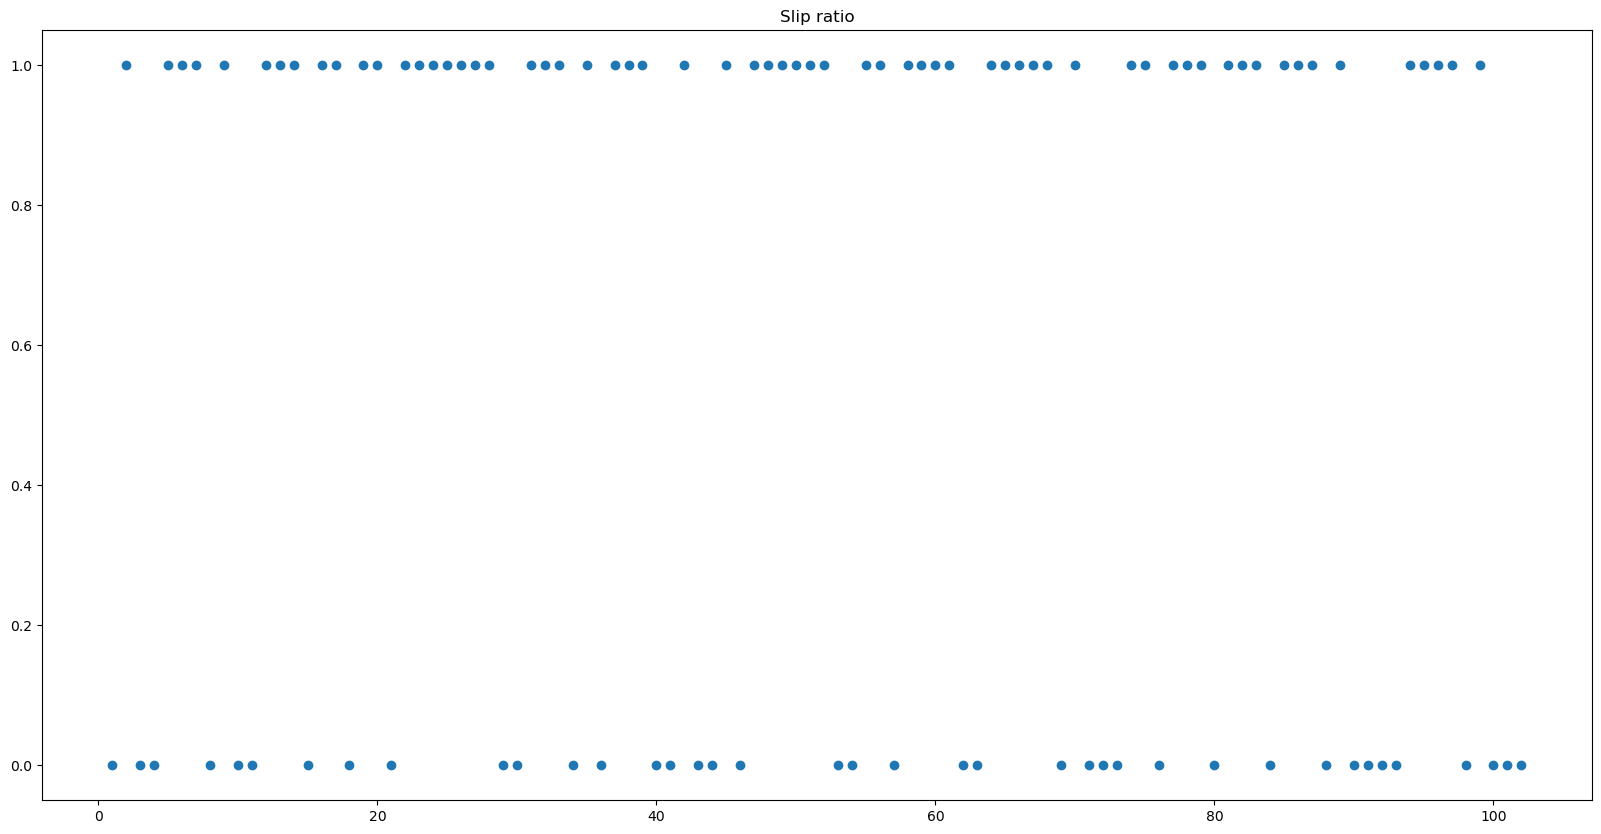

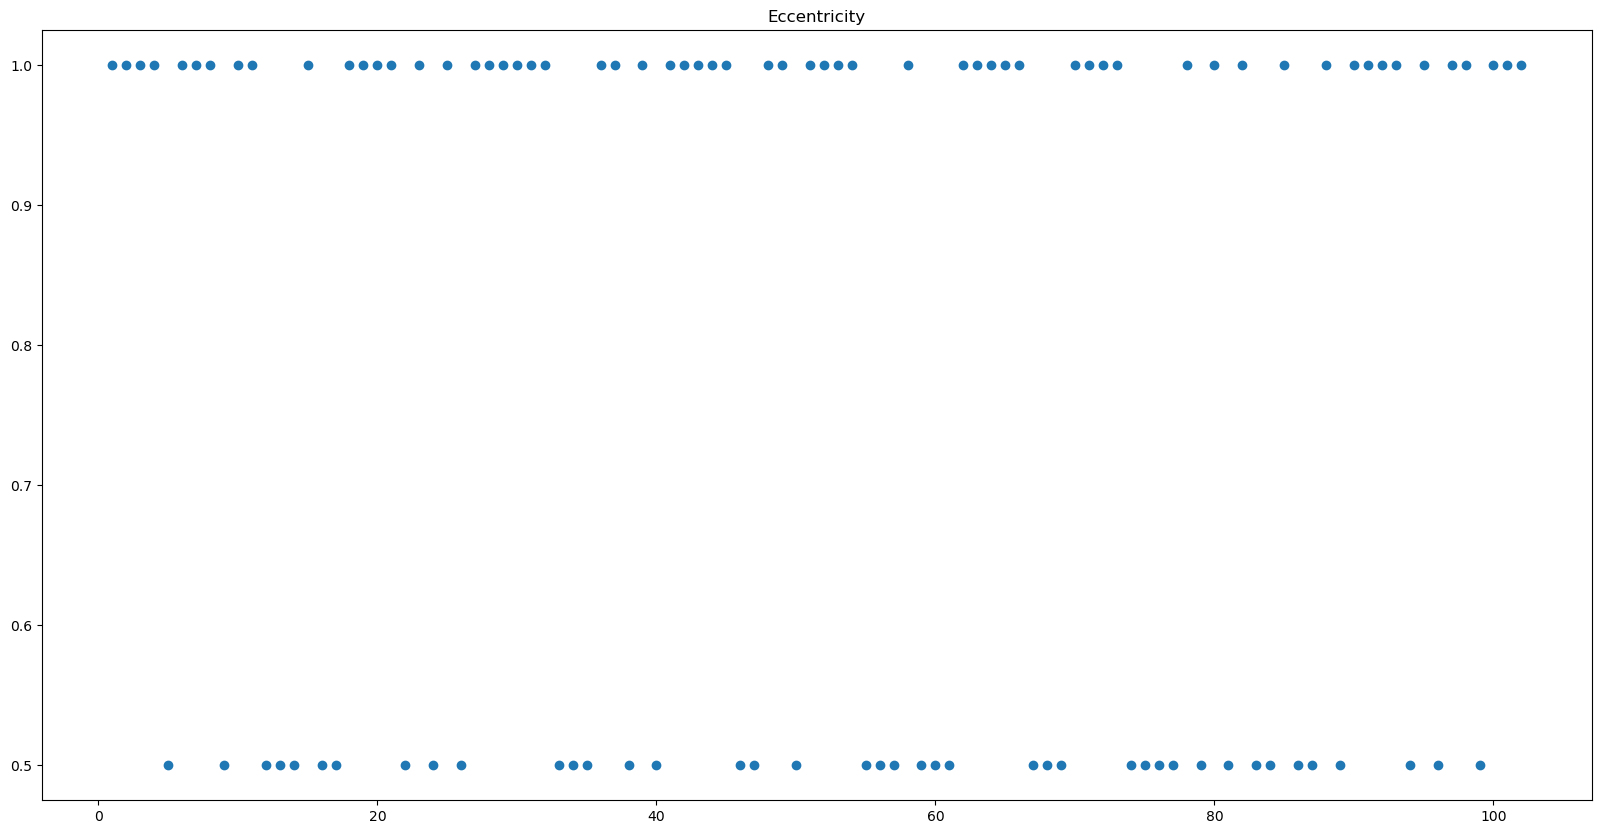

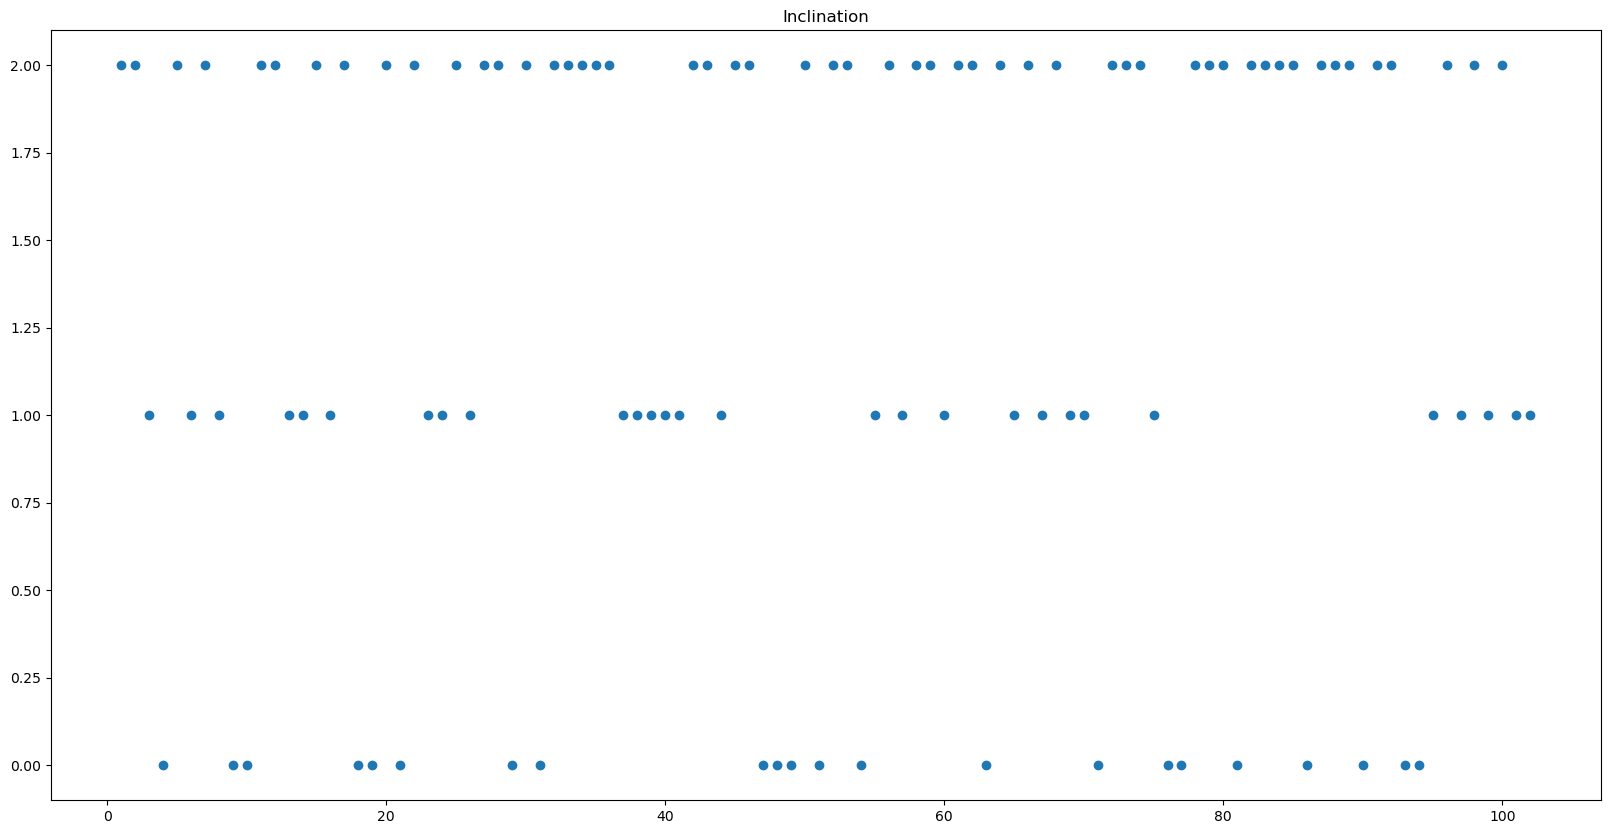

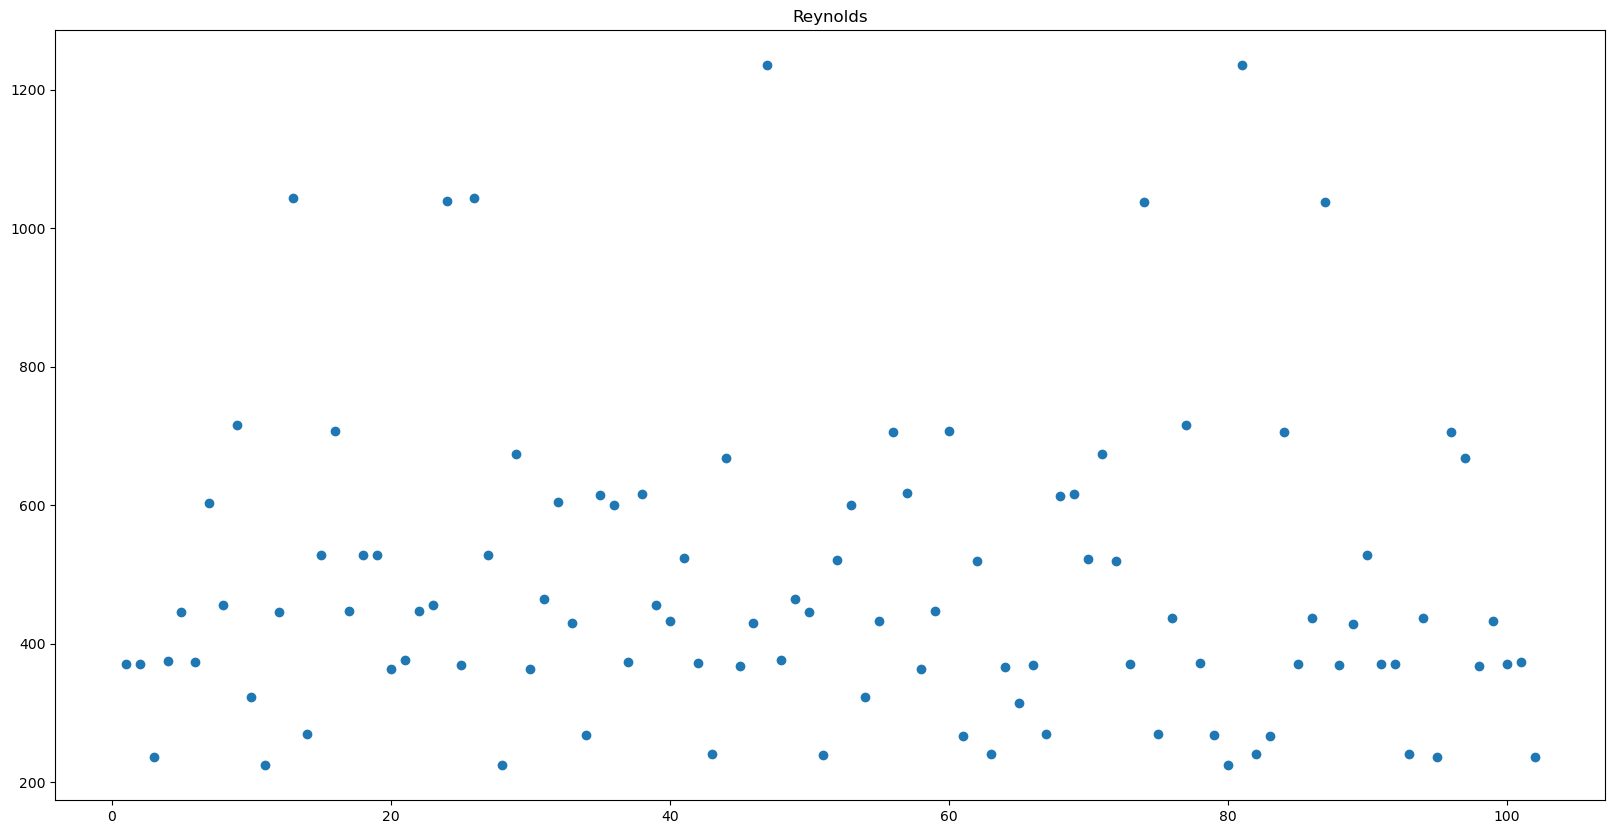

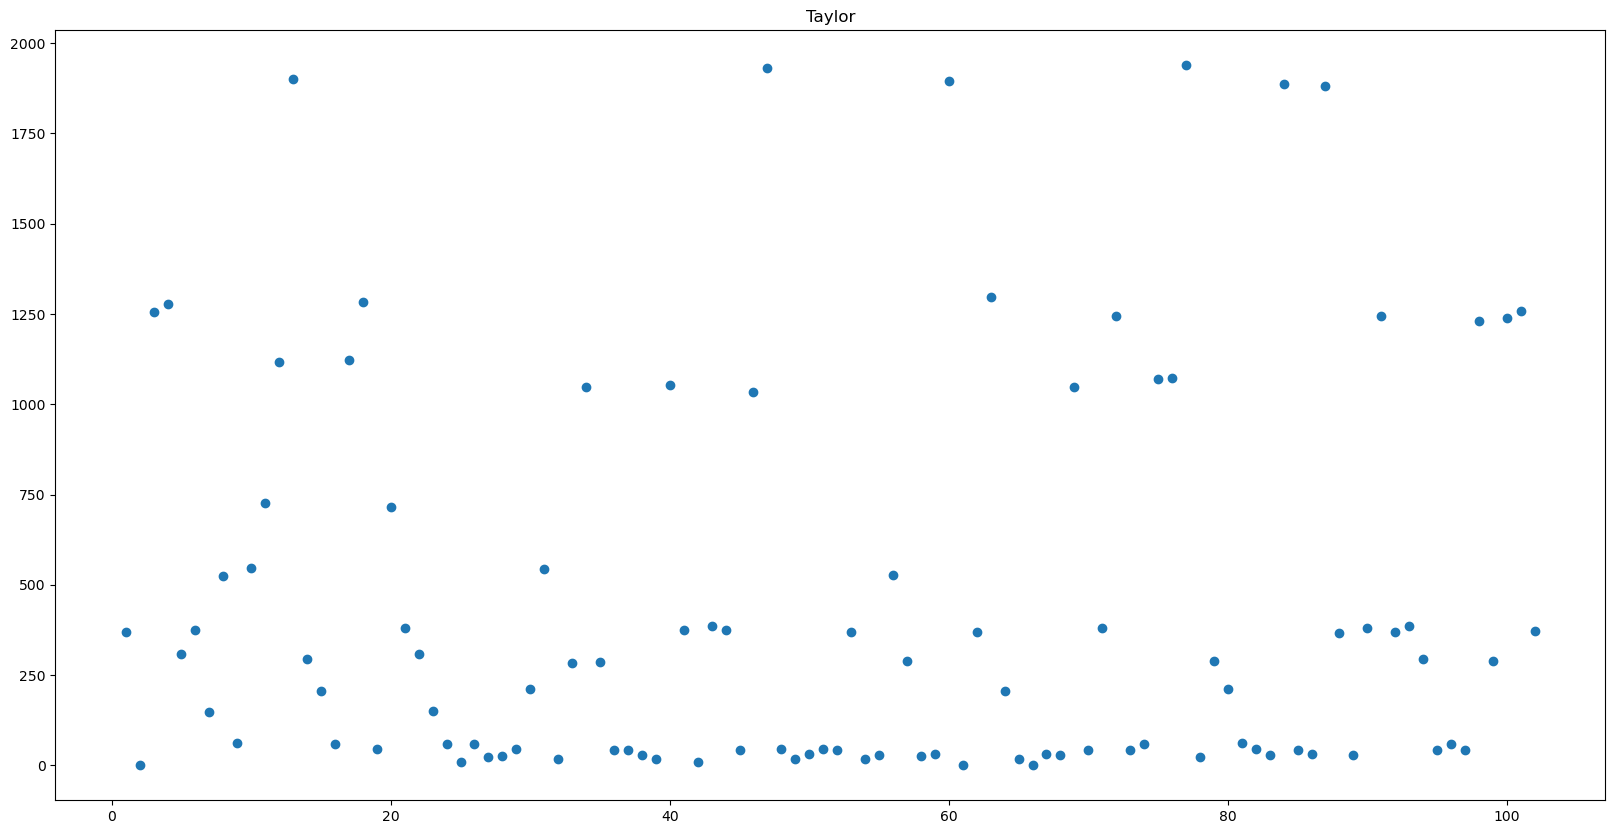

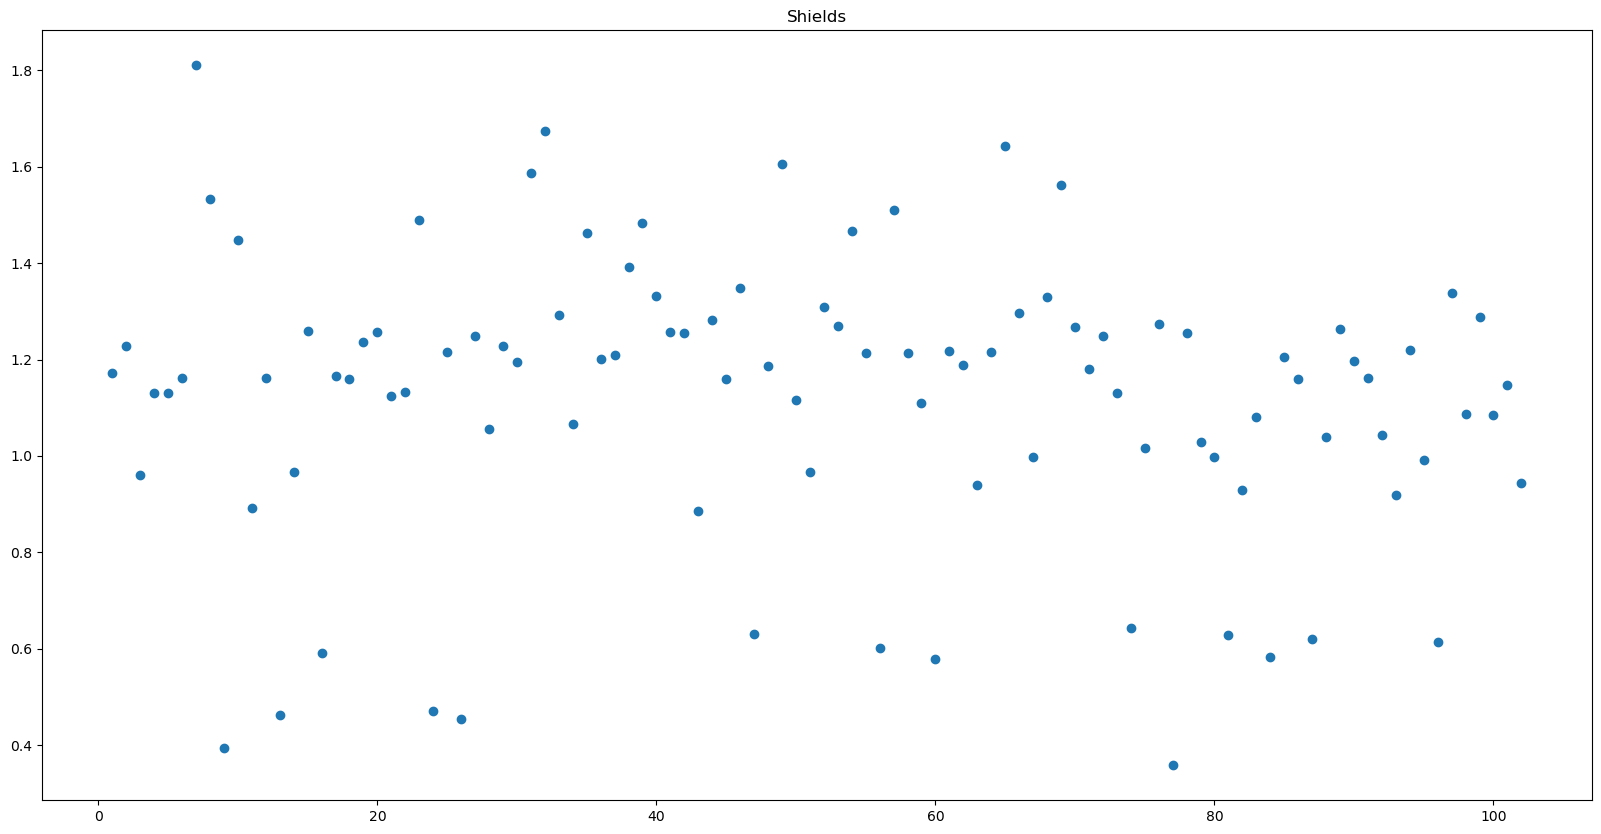

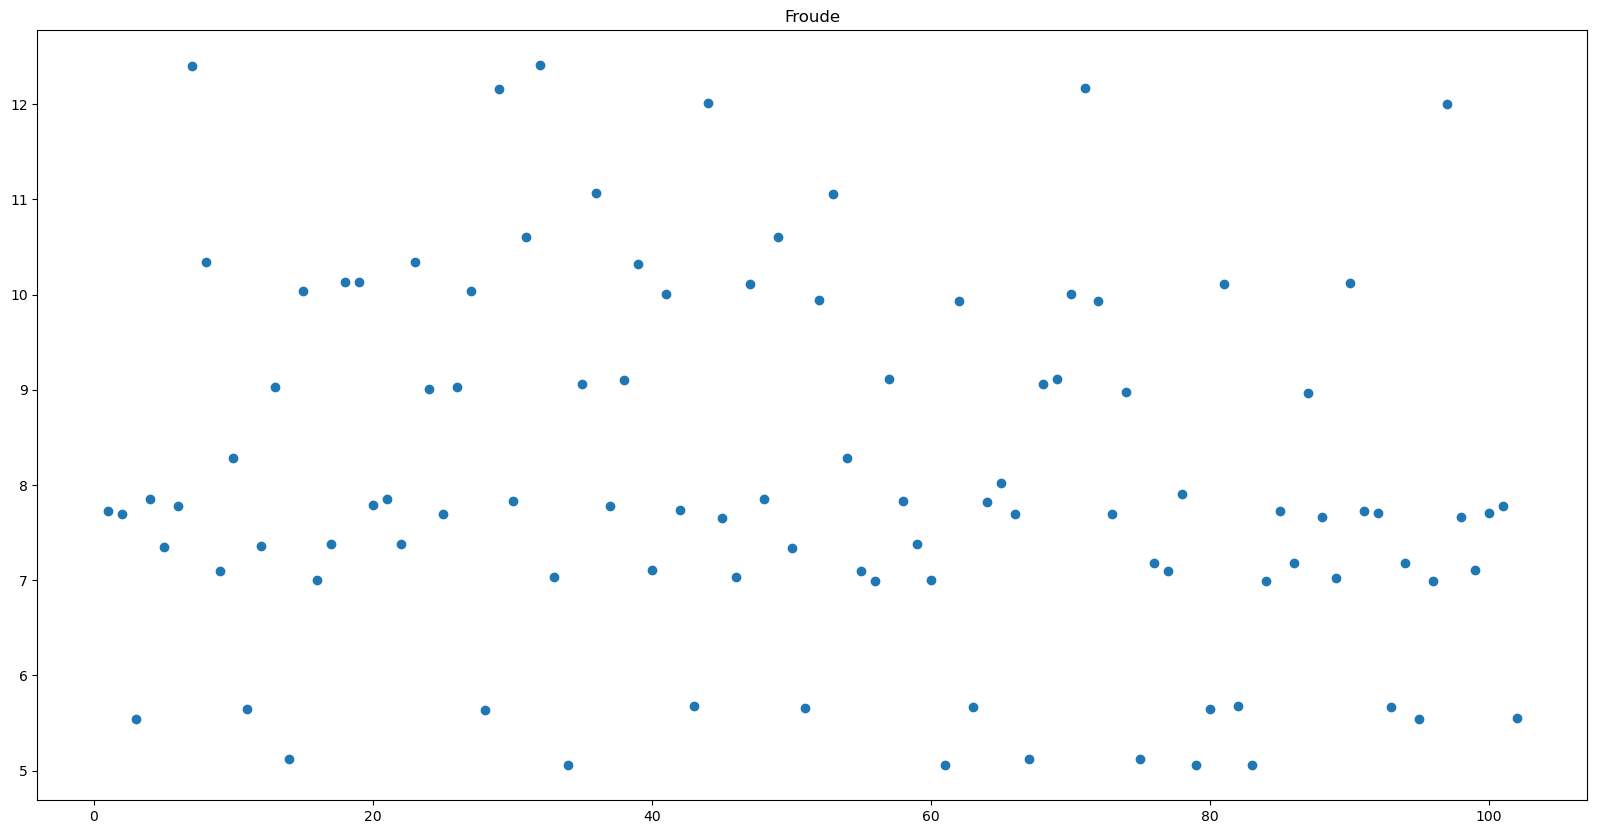

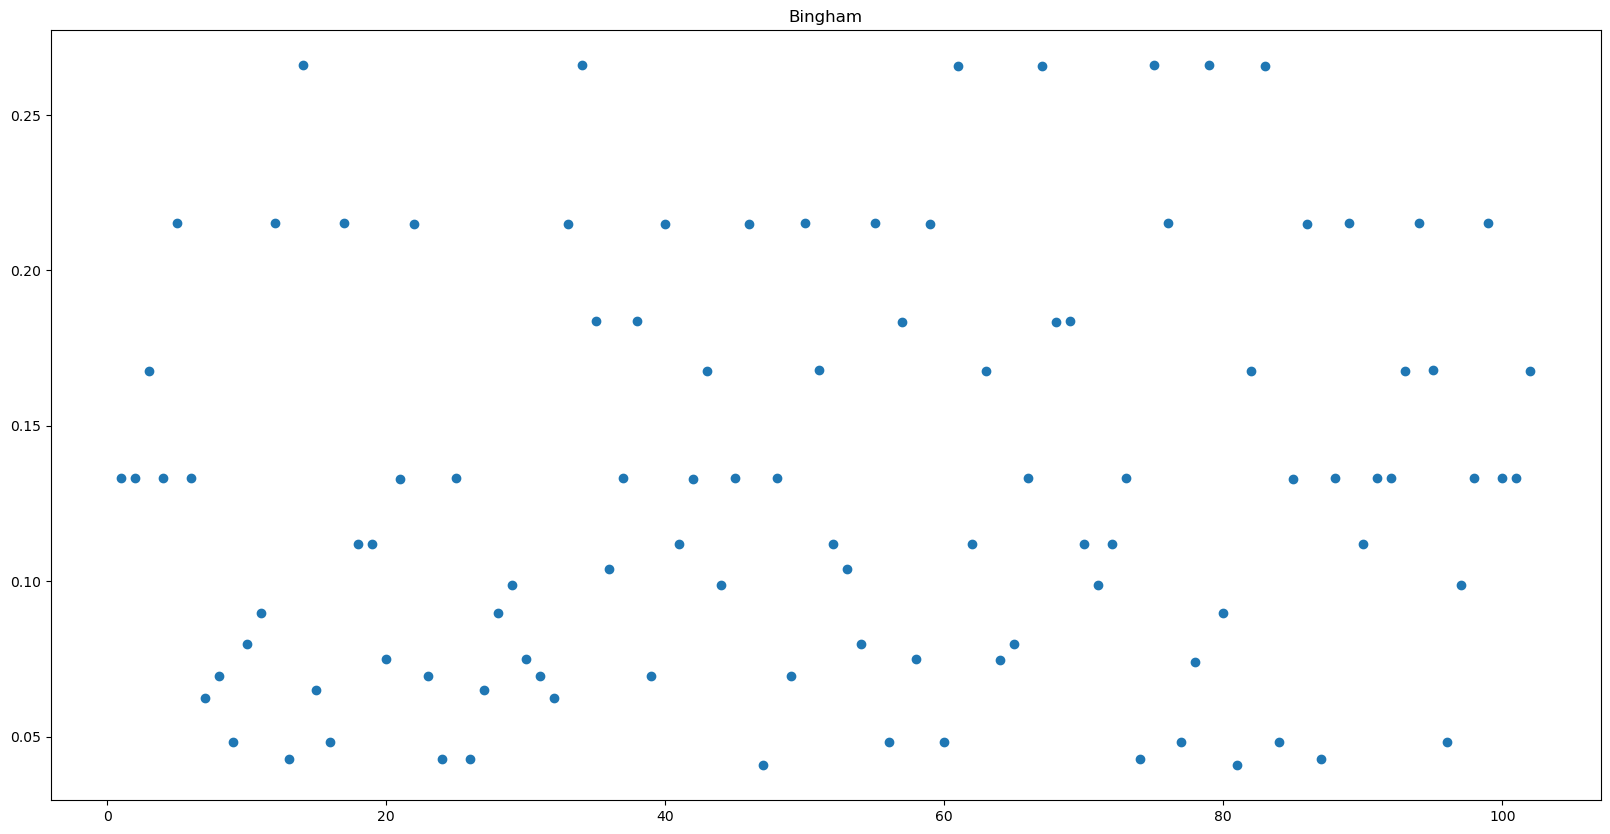

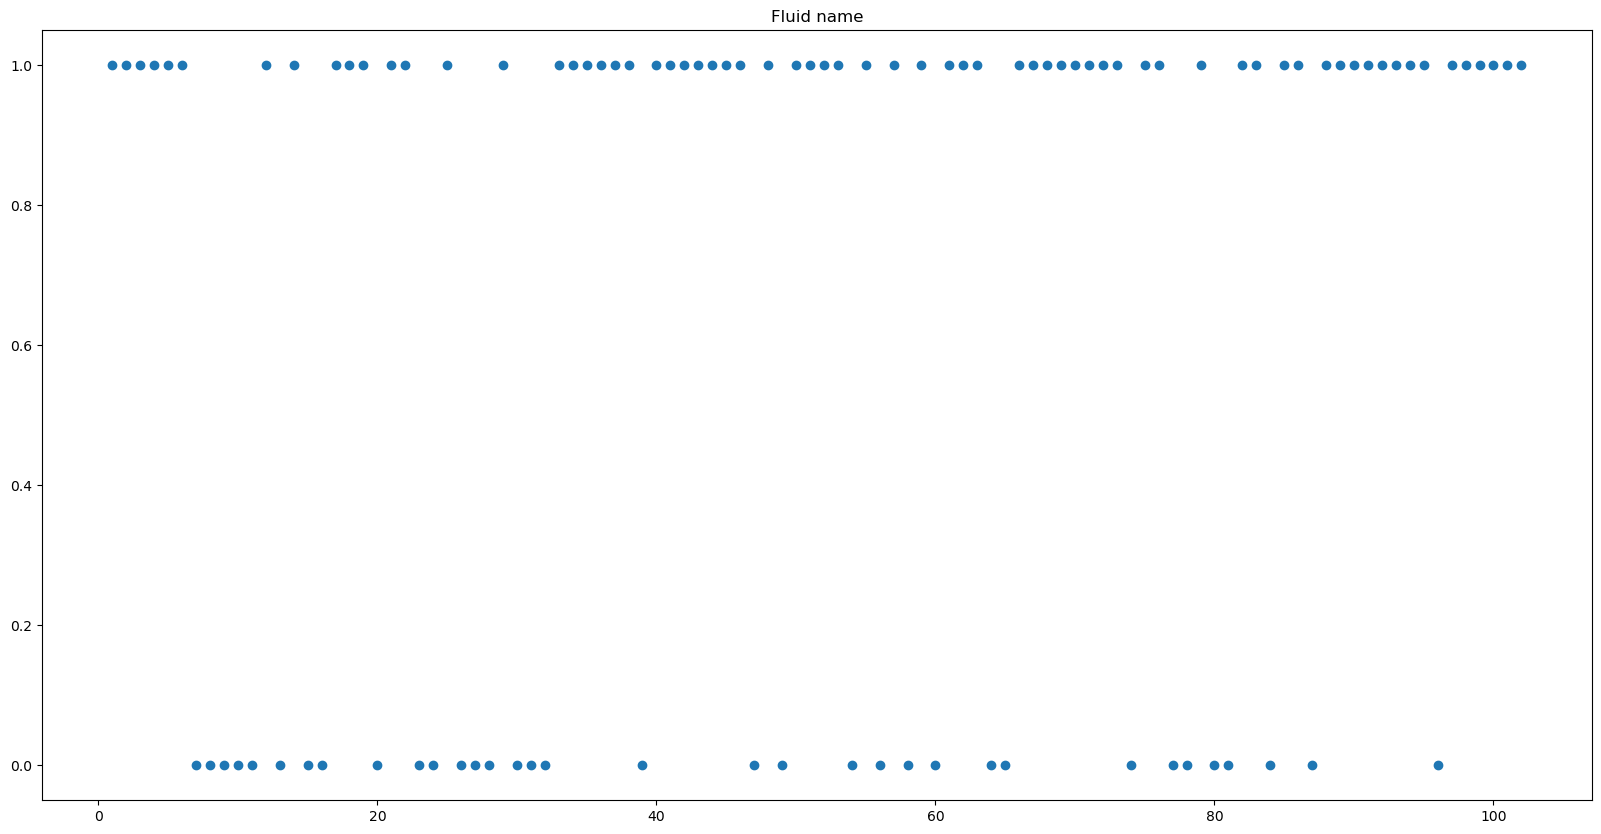

In [57]:
x_points = np.arange(1, len(df)+1,1)
for column in df:
    plt.figure(figsize=(20,10))
    plt.title(column)
    plt.scatter(x_points,df[column].values)
    plt.show()

In [58]:
print(df.isna().sum())

Slip ratio      0
Eccentricity    0
Inclination     0
Reynolds        0
Taylor          0
Shields         0
Froude          0
Bingham         0
Fluid name      0
dtype: int64


In [59]:
param_grid = { 
    'C': [1e-2, 0.1, 1.0],
    'gamma': [1e-4, 1e-3, 1e-2],
    'kernel' : ['rbf','linear','poly'],
}

In [60]:

n_splits = 5
k_fold_inner = KFold(n_splits = n_splits, shuffle = True, random_state = 42)
k_fold_outer = KFold(n_splits = n_splits, shuffle = True, random_state = 42)
data_k_fold, best_fold, best_model,avg_acc = k_fold_cross_validation_sklearn_models(df=df,split_percentage=0.9,model=SVC,n_splits=n_splits,kfold_outer=k_fold_outer, kfold_inner=k_fold_inner, param_grid=param_grid)

Best model found for fold: 2 with accuracy of 0.72 average accuracy is:  0.6380116959064328


In [61]:
features_best_model = data_k_fold["Final training features"]
targets_best_model = data_k_fold["Final training targets"]
features_best_model.shape

(91, 8)

In [62]:
# True negatives are (0,0) and true positives are (1,1) false positives are (1,0) and false negatives are (0,1)
test_confmat = data_k_fold["Test confmat"]
test_accuracy = round((test_confmat[0,0] + test_confmat[1,1]) / np.sum(test_confmat),2)
sensitivity = test_confmat[1,1] / (test_confmat[0,1] + test_confmat[1,1])
specificity = test_confmat[0,0] / (test_confmat[0,0] + test_confmat[1,0])
print(test_confmat)
print("Testing accuracy is: ",test_accuracy)
print("Sensitivity is:", round(sensitivity,2), " and specificity is: ", round(specificity,2))

[[0 0]
 [6 5]]
Testing accuracy is:  0.45
Sensitivity is: 1.0  and specificity is:  0.0


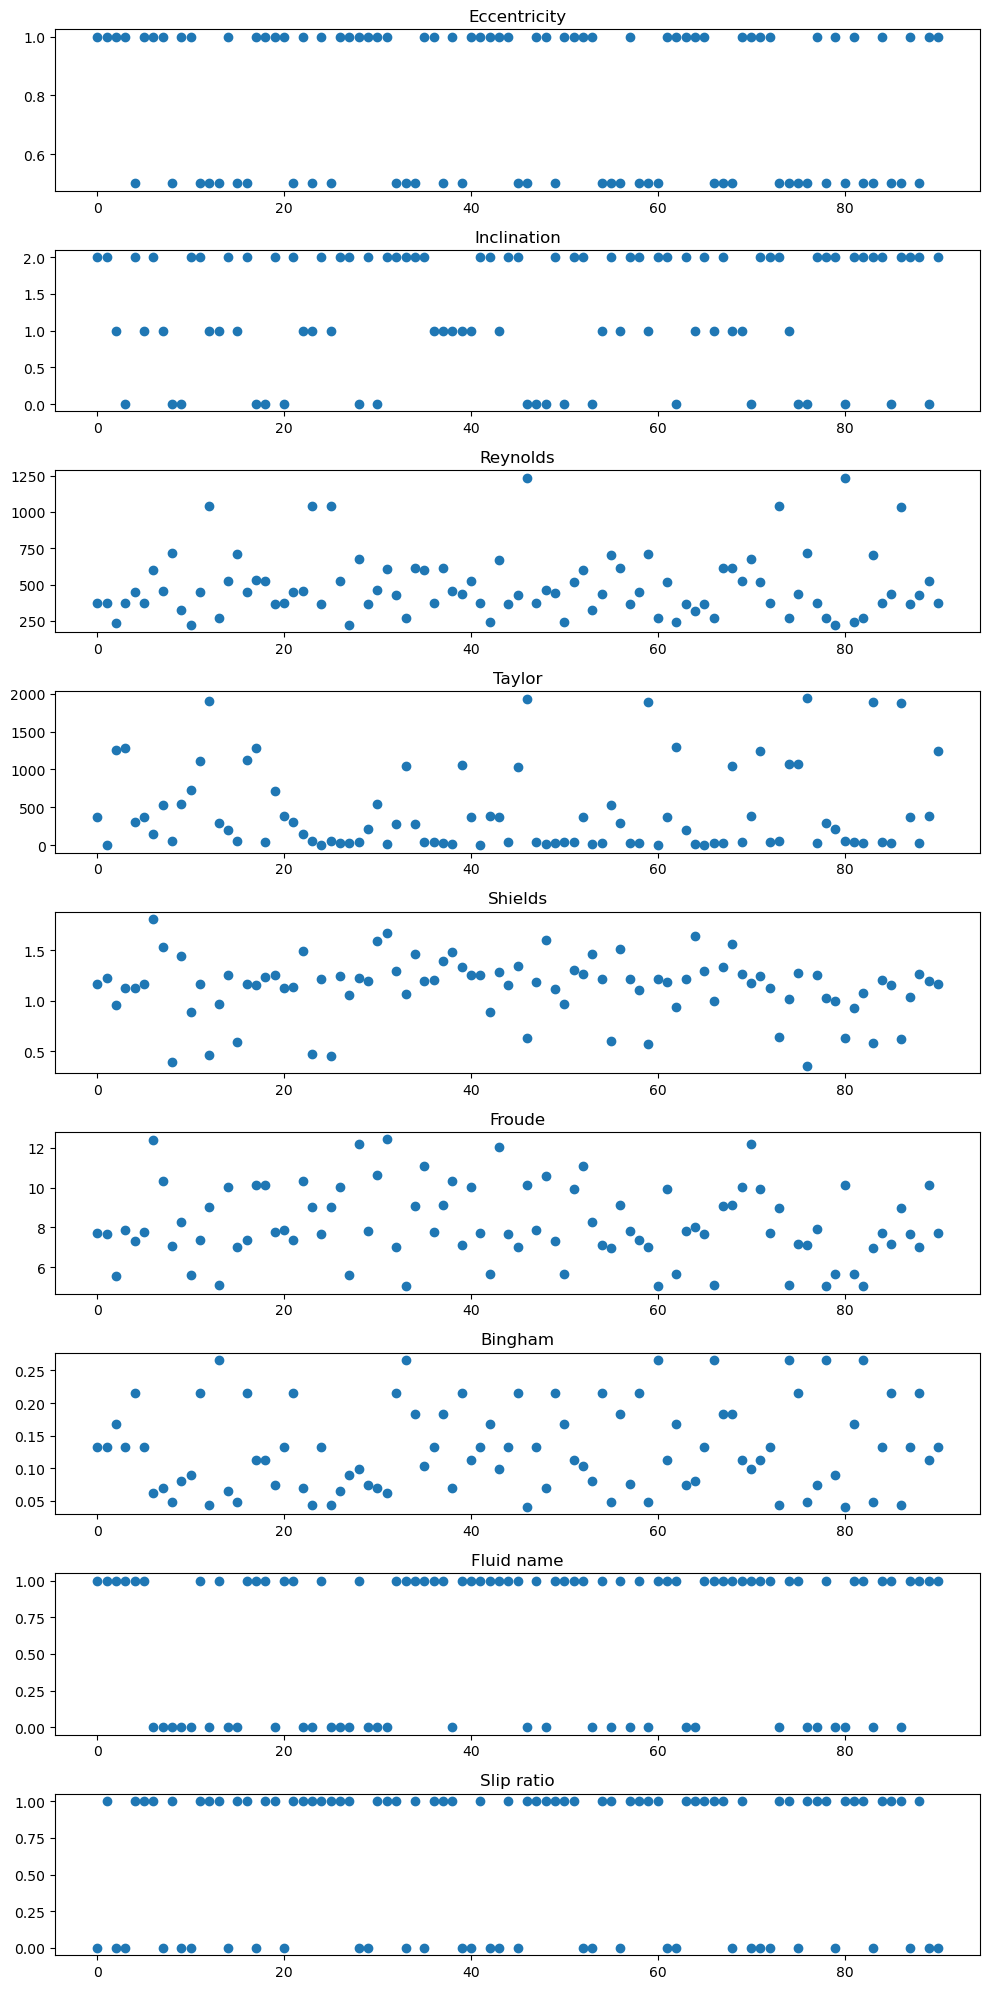

In [63]:
number_of_points_during_training = len(features_best_model[:,0])
number_of_features = len(features_best_model[0,:])
name_features = ["Eccentricity"  , "Inclination" , "Reynolds" , "Taylor" , "Shields" , "Froude" , "Bingham" , "Fluid name"]
fig, ax = plt.subplots(number_of_features+1, figsize = (10,20))
x_vals_for_scatter = np.arange(0,number_of_points_during_training,1)
for i in range(number_of_features):
    ax[i].set_title(name_features[i])
    ax[i].scatter(x_vals_for_scatter,features_best_model[:,i])
ax[number_of_features].set_title("Slip ratio")
ax[number_of_features].scatter(x_vals_for_scatter,targets_best_model[:])
plt.tight_layout()

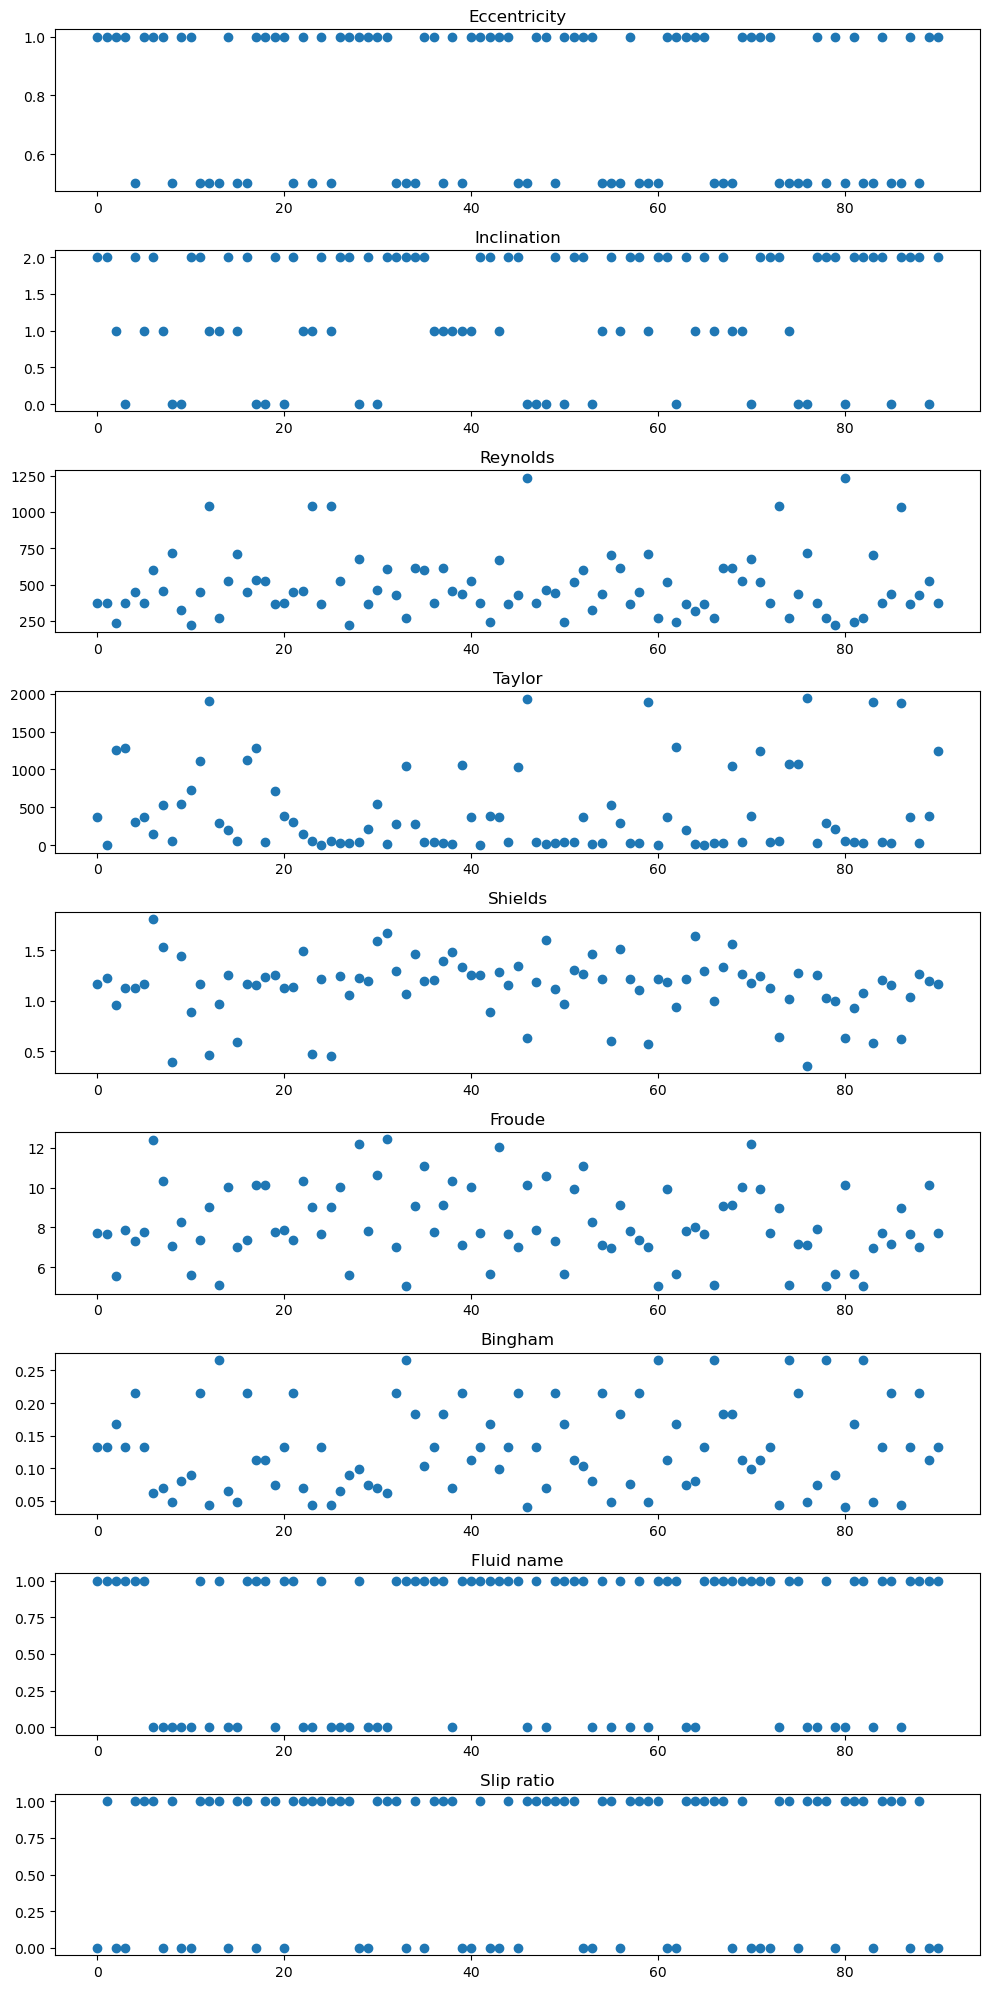

In [64]:
test_features = data_k_fold["Test features"]
test_targets = data_k_fold["Test targets"]
number_of_points_during_training = len(features_best_model[:,0])
number_of_features = len(features_best_model[0,:])
name_features = ["Eccentricity"  , "Inclination" , "Reynolds" , "Taylor" , "Shields" , "Froude" , "Bingham" , "Fluid name"]
fig, ax = plt.subplots(number_of_features+1, figsize = (10,20))
x_vals_for_scatter = np.arange(0,number_of_points_during_training,1)
for i in range(number_of_features):
    ax[i].set_title(name_features[i])
    ax[i].scatter(x_vals_for_scatter,features_best_model[:,i])
ax[number_of_features].set_title("Slip ratio")
ax[number_of_features].scatter(x_vals_for_scatter,targets_best_model[:])
plt.tight_layout()

In [ ]:
best_model.get_params()